In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle
from torchvision import transforms

from get3d_utils import constructGenerator, eval_get3d_angles, generate_rotate_camera_list, save_textured_mesh

In [5]:
def preprocess_rgb(array):
    img = array
    img = transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])(img)
    img = img.transpose(1, 3)
    img = img.transpose(1, 2)
    img = img.clip(0., 1.)
    return img.cpu().numpy()

In [6]:
with open('test.pickle', 'rb') as f:
        generator_args = pickle.load(f)

G_ema = constructGenerator(**generator_args)

constructing
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
==> resume from pretrained path pretrained_model/shapenet_car.pt


In [7]:
torch.manual_seed(0)

In [8]:
text_prompt = 'Lamborghini'

loss_types = ['directional']
#loss_types = ['pae']

states = {}

for loss_type in loss_types:
    states[loss_type] = torch.load(f'generators_saved/{text_prompt}_{loss_type}_generator.pt')

In [9]:
import copy

original_state_dict = copy.deepcopy(G_ema.state_dict())

In [10]:
n_samples = 30

z_geo = torch.randn(n_samples, 512).to('cuda')
z_tex = torch.randn(n_samples, 512).to('cuda')

with torch.no_grad():
    ws_geo = G_ema.mapping_geo(z_geo, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)
    ws_tex = G_ema.mapping(z_tex, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)

In [ ]:
# Saving Original Textured Meshes
for i, _ in enumerate(ws_geo):
        save_textured_mesh(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), f'eval_meshes/original/{i}.obj')

In [21]:
# Saving Textured Meshes
with torch.no_grad():
    # for i, _ in enumerate(ws_geo):
    #     save_textured_mesh(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), f'eval_meshes/weight_editing/original/{text_prompt}/{i}.obj')
    for loss_type in loss_types:
        G_ema.load_state_dict(states[loss_type])
        for i, _ in enumerate(ws_geo):
            save_textured_mesh(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), f'eval_meshes/weight_editing/{loss_type}/{text_prompt}/{i}.obj')
        torch.cuda.empty_cache()


In [11]:
# Rendering Images

with torch.no_grad():
    camera_idxs = [0, 4, 8, 12, 16]
    cameras = generate_rotate_camera_list()
    cameras = [camera for i, camera in enumerate(cameras) if i in camera_idxs]
    imgs = []
    for i, _ in enumerate(ws_geo):
        G_ema.load_state_dict(original_state_dict)
        img_original = eval_get3d_angles(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), cameras=cameras, intermediate_space=True).cpu()
        imgs.append(img_original)
    for loss_type in loss_types:
        G_ema.load_state_dict(states[loss_type])
        for i, _ in enumerate(ws_geo):
            img_edited = eval_get3d_angles(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), cameras=cameras, intermediate_space=True).cpu()
            imgs.append(img_edited)
        torch.cuda.empty_cache()

/home/windows-ssh/git/GET3D/get3d_utils.py:351: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device='cuda').unsqueeze(dim=-1) / n_camera * math.pi * 2.0


In [12]:
imgs = torch.cat(imgs)

In [13]:
with torch.no_grad():
    preprocessed_imgs = preprocess_rgb(imgs)

In [14]:
preprocessed_imgs = preprocessed_imgs.reshape(-1, n_samples, len(cameras), 1024, 1024, 3).swapaxes(0, 1).reshape(-1, 1024, 1024, 3)

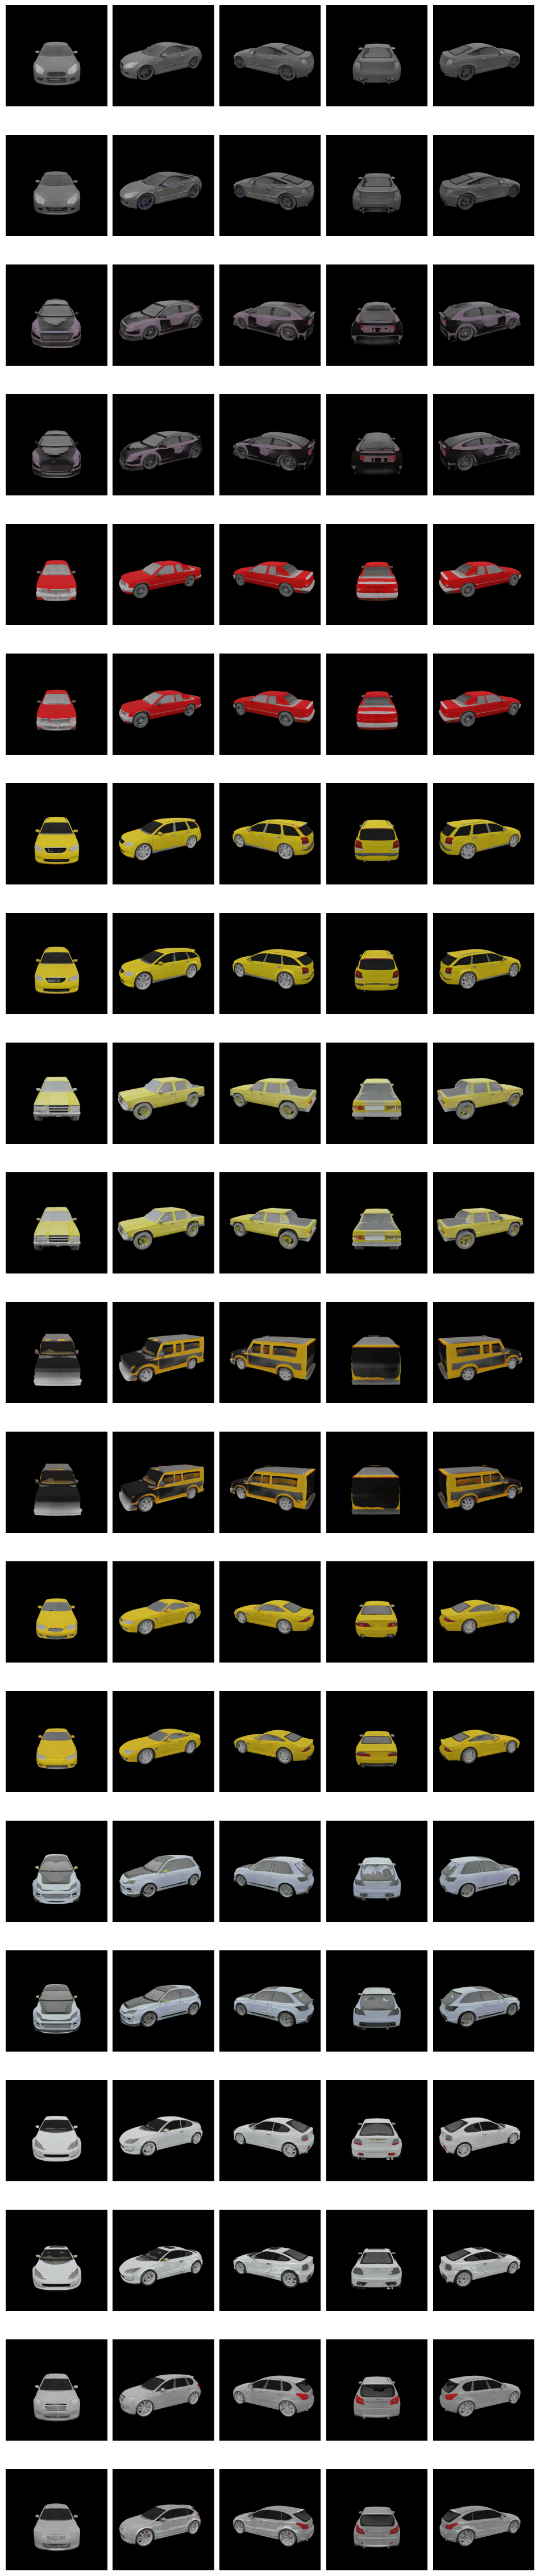

In [15]:
from mpl_toolkits.axes_grid1 import ImageGrid

n_show = 10

fig = plt.figure(figsize=(12., 200.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n_show * (len(loss_types) + 1), len(cameras)),
                 axes_pad=(0.1, 0.5),
                 )

for i, (ax, im) in enumerate(zip(grid, preprocessed_imgs[:n_show * (len(loss_types) + 1) * len(cameras)])):
    ax.axis('off')
    #ax.set_title(f'{i}')
    ax.imshow(im)

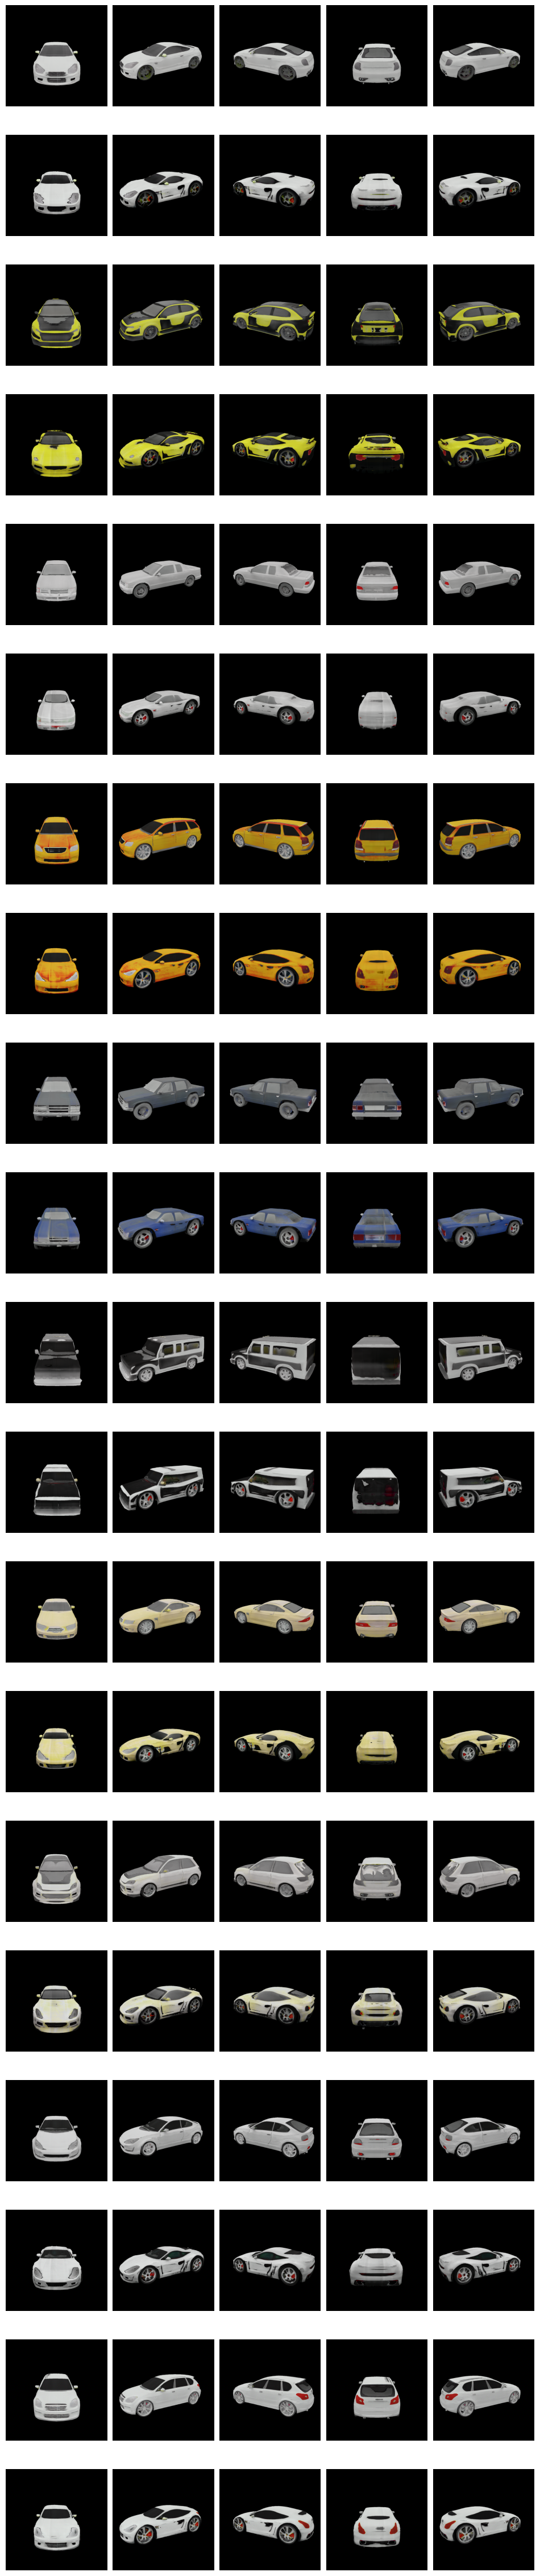

In [15]:
from mpl_toolkits.axes_grid1 import ImageGrid

n_show = 10

fig = plt.figure(figsize=(12., 200.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n_show * (len(loss_types) + 1), len(cameras)),
                 axes_pad=(0.1, 0.5),
                 )

for i, (ax, im) in enumerate(zip(grid, preprocessed_imgs[:n_show * (len(loss_types) + 1) * len(cameras)])):
    ax.axis('off')
    #ax.set_title(f'{i}')
    ax.imshow(im)

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
n_cameras = 3
with open(f'weight_transform_Lamborghini_directional_train_val_loss.pickle', 'rb') as f:
    loss_dict = pickle.load(f)

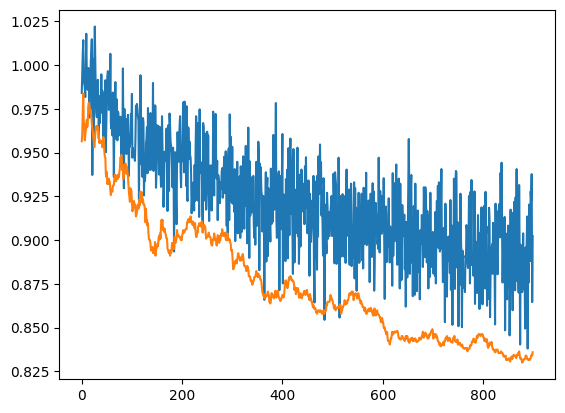

In [3]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train'])/5, label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

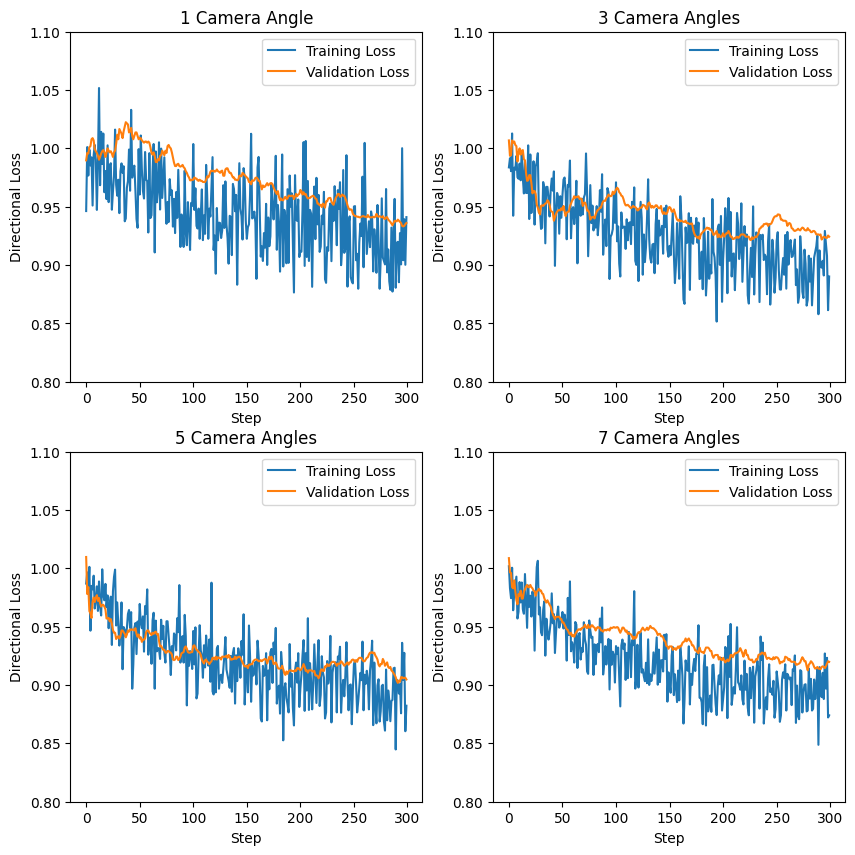

In [100]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
n_cameras = [1, 3, 5, 7]
for i in range(2):
    for j in range(2):
        n_cam = n_cameras[i*2+j]
        with open(f'weight_transform_{n_cam}_Sports Car_directional_train_val_loss.pickle', 'rb') as f:
            loss_dict = pickle.load(f)
        ax[i][j].plot(np.array(loss_dict['train']) / n_cam, label='Training Loss')
        ax[i][j].plot(np.array(loss_dict['val']), label='Validation Loss')
        ax[i][j].set_ylim(0.8, 1.1)
        ax[i][j].legend(loc='upper right')
        ax[i][j].set_xlabel('Step')
        ax[i][j].set_ylabel('Directional Loss')
        if n_cam == 1:
            ax[i][j].set_title(f'{n_cam} Camera Angle')
            continue
        ax[i][j].set_title(f'{n_cam} Camera Angles')
        
fig.savefig('Effect of camera angles.png')
plt.show()

In [19]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
with open('120_samples_weight_transform_Sports Car_directional_train_val_loss.pickle', 'rb') as f:
    loss_dict_120 = pickle.load(f)
with open('weight_transform_Sports Car_directional_train_val_loss.pickle', 'rb') as f:
    loss_dict_90 = pickle.load(f)
with open('60_samples_weight_transform_Sports Car_directional_train_val_loss.pickle', 'rb') as f:
    loss_dict_60 = pickle.load(f)
with open('30_samples_weight_transform_Sports Car_directional_train_val_loss.pickle', 'rb') as f:
    loss_dict_30 = pickle.load(f)

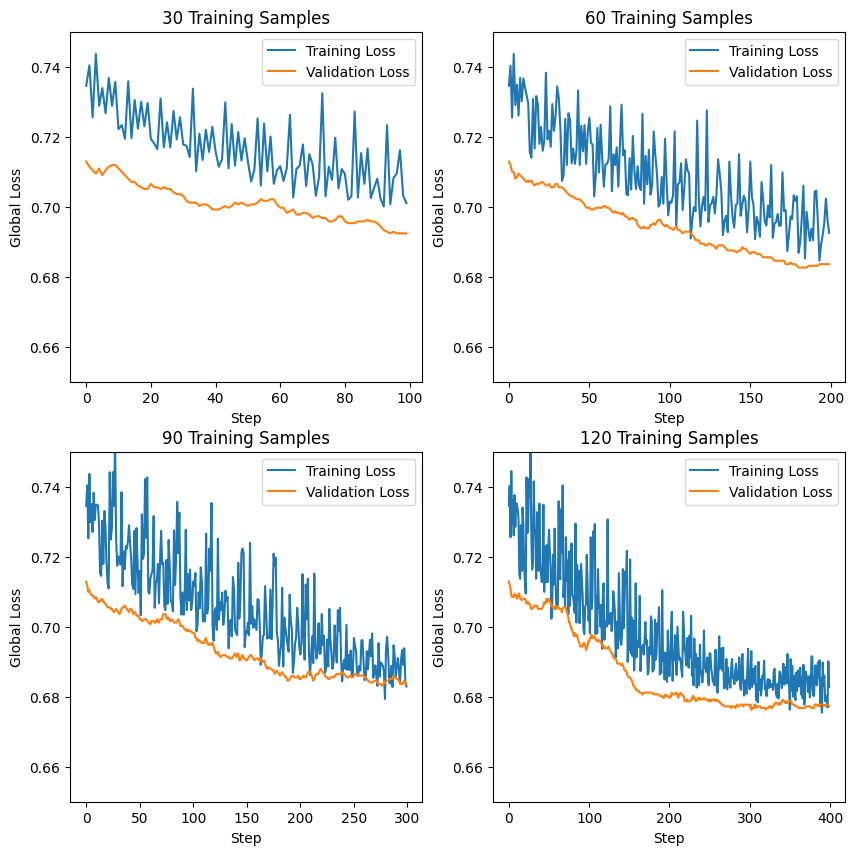

In [39]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
ax[0][0].plot(loss_dict_30['train'], label='Training Loss')
ax[0][0].plot(loss_dict_30['val'], label='Validation Loss')
ax[0][1].plot(loss_dict_60['train'], label='Training Loss')
ax[0][1].plot(loss_dict_60['val'], label='Validation Loss')
ax[1][0].plot(loss_dict_90['train'], label='Training Loss')
ax[1][0].plot(loss_dict_90['val'], label='Validation Loss')
ax[1][1].plot(loss_dict_120['train'], label='Training Loss')
ax[1][1].plot(loss_dict_120['val'], label='Validation Loss')
for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i][j].legend(loc='upper right')
        ax[i][j].set_ylim(0.65, 0.75)
        ax[i][j].set_title(f'{[30, 60, 90, 120][i*len(ax)+j]} Training Samples')
        ax[i][j].set_xlabel('Step')
        ax[i][j].set_ylabel('Global Loss')
plt.show()
fig.savefig("Effect of training sample size.png")

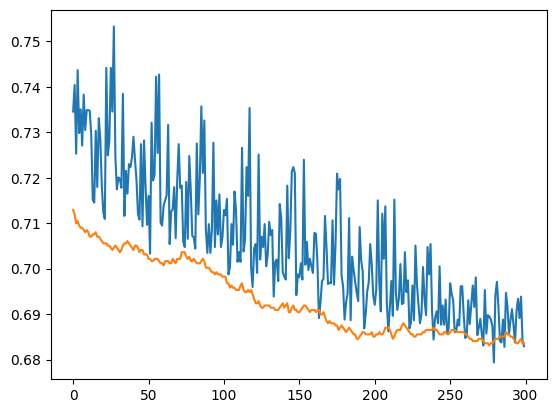

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

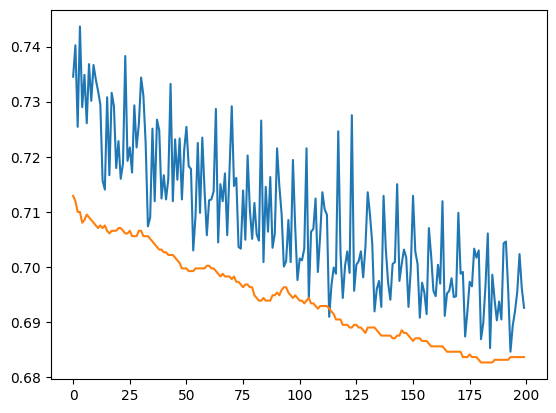

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

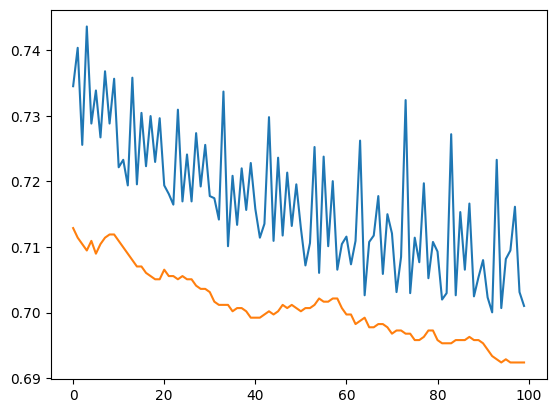

In [3]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
with open('weight_transform_Bugatti_directional_train_val_loss.pickle', 'rb') as f:
    loss_dict = pickle.load(f)

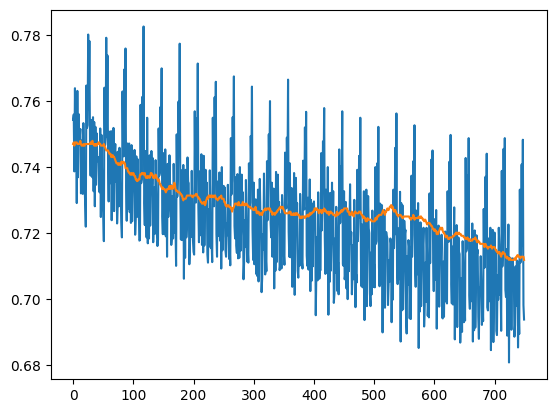

In [2]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

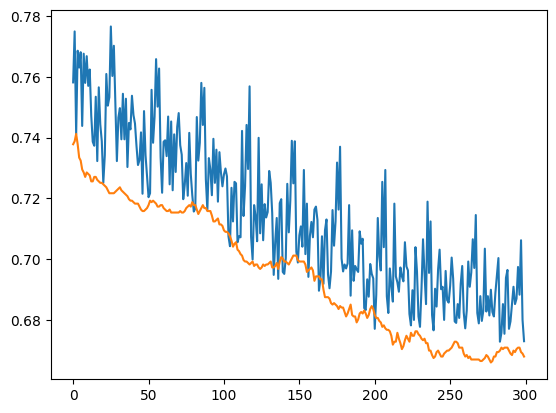

In [2]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')

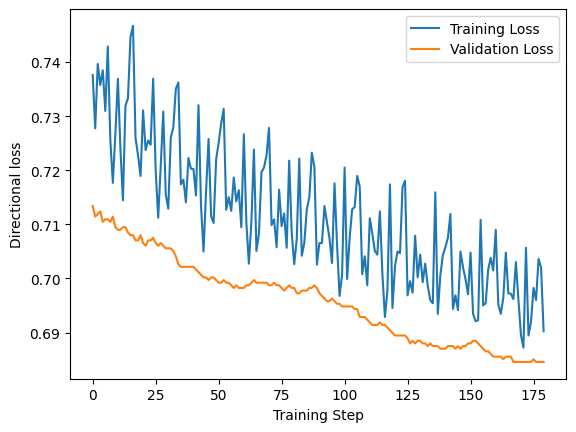

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
with open('weight_transform_Sports Car_directional_train_val_loss.pickle', 'rb') as f:
    loss_dict = pickle.load(f)

fig, ax = plt.subplots(1, 1)
ax.plot(np.array(loss_dict['train']), label='Training Loss')
ax.plot(np.array(loss_dict['val']), label='Validation Loss')
ax.set_xlabel('Training Step')
ax.set_ylabel('Directional loss')
ax.legend()
plt.show()
fig.savefig('Weight Editing Directional Training.png')

In [22]:
with open('weight_editing_Sports Car.pkl', 'wb') as f:
    pickle.dump(imgs, f)

In [12]:
with open('image_sample.pkl', 'wb') as f:
    pickle.dump(imgs, f)

In [2]:
import pickle
import numpy as np

with open('weight_transform_grads_1.pickle', 'rb') as f:
    grads = pickle.load(f)

In [3]:
grads = np.array(grads)

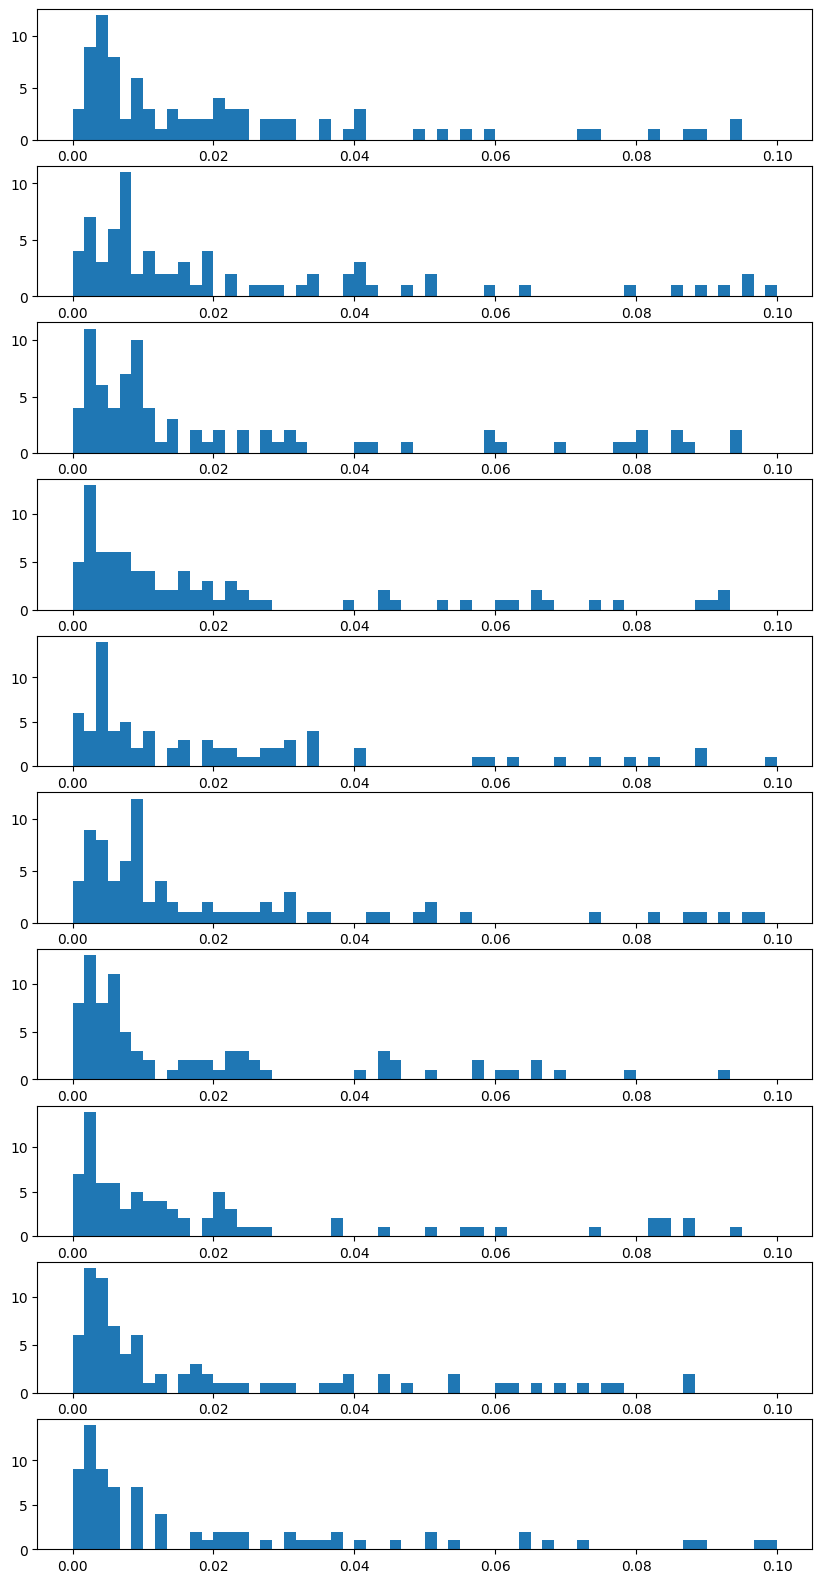

In [12]:
import matplotlib.pyplot as plt

n_hist = 10
fig, ax = plt.subplots(n_hist, 1)
fig.set_size_inches(10, 20)
step = int(grads.shape[0] / n_hist)
for i, grad in enumerate(grads[::step]):
    counts, bins = np.histogram(grad, bins=60, range=(0.0, 0.1))
    ax[i].stairs(counts, bins, fill=True)